In [152]:
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

from tensorboardX import SummaryWriter
writer = SummaryWriter()

from torchvision import models

# 1. 데이터 불러오기

In [ ]:
# MEAN = (0.485, 0.456, 0.406) # 해당 데이터는 정규화시 사용되는 평균값으로, 실제 데이터의 평규값을 구해야합니다.
# STD = (0.229, 0.224, 0.225)  # 해당 데이터는 정규화시 사용되는 표준편차값으로, 실제 데이터의 표준편차값 구해야합니다.

transforms_train = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    RandomHorizontalFlip(p=0.5),        # 과적합을 막기 위해 이미지를 랜덤으로 좌우 대칭을 변환합니다.
    transforms.Grayscale(num_output_channels=3),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    transforms.Grayscale(num_output_channels=3),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

# ImageFolder 함수를 사용하여 이미지를 불러옵니다.
# train 폴더 내부에는 내가 분류하고 싶은 이미지별로 폴더 정리가 되어있어야 합니다
# 이 프로젝트에서는 [Normal, PNEUMONIA] 두개의 폴더로 분류가 되어있습니다.
# Normal 은 label 0번, PNEUMONIA 은 label 1번으로 라벨링됩니다.
# ImageFolder 함수는 이미지를 불러오는 동시에, 폴더 위치별로 정답 데이터가 라벨링 됩니다.
train_datasets = datasets.ImageFolder(root="data/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="data/test", transform=transforms_test)
val_datasets = datasets.ImageFolder(root="data/val", transform=transforms_test) # 평가용 데이터 준비

## 데이터 확인해보기

### 학습 데이터 수 확인

In [99]:
len(train_datasets) 

5216

### 분류할 클래스 리스트 보기

In [100]:
train_datasets.classes

['NORMAL', 'PNEUMONIA']

### 이미지 그리기

In [101]:
import numpy as np

# def denormalize(image, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)
#     std = torch.tensor(std).view(3, 1, 1)
#     return image * std + mean

def view_img(tensor_image, title="title", cmap=None):
    """
    PyTorch 텐서(Tensor)를 시각화하는 함수
    """
    # 텐서를 넘파이 배열로 변환
    img_data = tensor_image.numpy()

    # 이미지 차원 순서 변경
    # PyTorch: (채널, 높이, 너비) -> Matplotlib: (높이, 너비, 채널)
    plt.imshow(np.transpose(img_data, (1, 2, 0)), cmap=cmap)

    # 이미지에 제목을 설정하고 화면에 표시
    plt.title(title)
    plt.show()

### + 튜플 데이터 타입에 대해서

In [102]:
tu = ('김서영', 99)
item0 = tu[0]
item1 = tu[1]
print(item0, item1)

name, year = tu
print(name, year)

김서영 99
김서영 99


In [103]:
image, label = train_datasets[0]
print(image) # 이미지
print(label) # 0
print(train_datasets.classes[label]) # NORMAL

tensor([[[0.0874, 0.0784, 0.0735,  ..., 0.3713, 0.3714, 0.3728],
         [0.0867, 0.0831, 0.0737,  ..., 0.3665, 0.3710, 0.3727],
         [0.0895, 0.0829, 0.0753,  ..., 0.3661, 0.3671, 0.3636],
         ...,
         [0.1160, 0.1141, 0.1090,  ..., 0.2343, 0.2354, 0.2362],
         [0.1356, 0.1359, 0.1332,  ..., 0.3163, 0.3196, 0.3225],
         [0.1773, 0.1761, 0.1752,  ..., 0.4201, 0.4246, 0.4254]],

        [[0.0874, 0.0784, 0.0735,  ..., 0.3713, 0.3714, 0.3728],
         [0.0867, 0.0831, 0.0737,  ..., 0.3665, 0.3710, 0.3727],
         [0.0895, 0.0829, 0.0753,  ..., 0.3661, 0.3671, 0.3636],
         ...,
         [0.1160, 0.1141, 0.1090,  ..., 0.2343, 0.2354, 0.2362],
         [0.1356, 0.1359, 0.1332,  ..., 0.3163, 0.3196, 0.3225],
         [0.1773, 0.1761, 0.1752,  ..., 0.4201, 0.4246, 0.4254]],

        [[0.0874, 0.0784, 0.0735,  ..., 0.3713, 0.3714, 0.3728],
         [0.0867, 0.0831, 0.0737,  ..., 0.3665, 0.3710, 0.3727],
         [0.0895, 0.0829, 0.0753,  ..., 0.3661, 0.3671, 0.

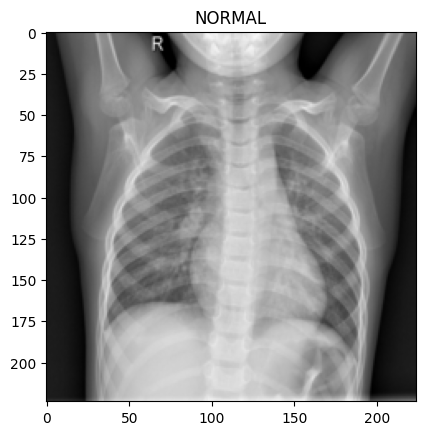

In [104]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

In [105]:
image, label = train_datasets[5000]
print(image) # 이미지
print(label) # 1
print(train_datasets.classes[label]) # PNEUMONIA

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.4365e-01,
          2.2410e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.4365e-01,
          2.2410e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.4301e-01,
          2.2404e-01, 0.0000e+00],
         ...,
         [1.0842e-02, 8.6153e-03, 7.8594e-05,  ..., 7.8671e-05,
          8.6155e-03, 1.0841e-02],
         [1.8764e-01, 1.6591e-02, 9.2533e-05,  ..., 9.2624e-05,
          1.6593e-02, 1.8764e-01],
         [5.5913e-02, 8.4965e-03, 2.8506e-05,  ..., 2.8534e-05,
          8.4970e-03, 5.5914e-02]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.4365e-01,
          2.2410e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.4365e-01,
          2.2410e-01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.4301e-01,
          2.2404e-01, 0.0000e+00],
         ...,
         [1.0842e-02, 8.6153e-03, 7.8594e-05,  ..., 7.8671e-05,
          8.615

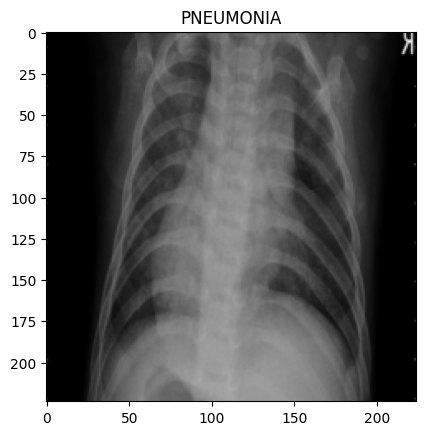

In [106]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

# 2. 데이터 배치사이즈로 분리하기

In [127]:
# DataLoader 를 사용하여 데이터를 나눈다
# batch_size 몇 개씩 그룹 지을지 정한다
# shuffle 데이터를 순서대로 나누는 것이 아니라 랜덤으로 섞어서 자른다 
# ⭐⭐ 학습에 영향을 줄 수 있으므로 Train Data 에는 True 로 설정 하자!
train_dataLoader = DataLoader(train_datasets, batch_size=32, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=32)
val_dataLoader = DataLoader(val_datasets, batch_size=32) # 평가용 데이터 준비

## 데이터 확인하기

tensor([[[2.0542e-01, 2.0825e-01, 2.1805e-01,  ..., 5.6070e-01,
          5.5088e-01, 5.3116e-01],
         [2.0447e-01, 2.1320e-01, 2.2672e-01,  ..., 5.6430e-01,
          5.4234e-01, 5.3413e-01],
         [2.0164e-01, 3.9697e-01, 5.9710e-01,  ..., 5.6534e-01,
          5.4927e-01, 5.2768e-01],
         ...,
         [5.5477e-03, 2.0805e-01, 3.7082e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.0840e-04, 3.8766e-03, 4.9277e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.0542e-01, 2.0825e-01, 2.1805e-01,  ..., 5.6070e-01,
          5.5088e-01, 5.3116e-01],
         [2.0447e-01, 2.1320e-01, 2.2672e-01,  ..., 5.6430e-01,
          5.4234e-01, 5.3413e-01],
         [2.0164e-01, 3.9697e-01, 5.9710e-01,  ..., 5.6534e-01,
          5.4927e-01, 5.2768e-01],
         ...,
         [5.5477e-03, 2.0805e-01, 3.7082e-01,  ..., 0.0000e+00,
          0.000

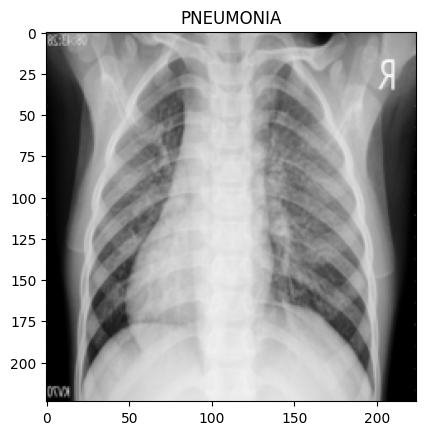

In [108]:
images, labels = next(iter(train_dataLoader)) # 튜플 (배치사이즈 만큼의 이미지들, 배치사이즈 만큼의 정답들)
print(images[0])
print(labels[0])

view_img(images[0], train_datasets.classes[labels[0]], cmap='gray')

## 데이터 형태 확인하기

In [109]:
# 차원 수 확인하기
images.dim()

4

In [110]:
# 배치사이즈 수만큼 분리된 데이터의 형태 확인하기
# 각 차원의 의미: [배치사이즈, 채널수, 이미지 가로 사이즈, 이미지 세로 사이즈]
images.shape

torch.Size([32, 3, 224, 224])

In [111]:
# 이미지 한장의 데이터 형태 확인하기
images[0].shape

torch.Size([3, 224, 224])

## 이미지 그리드로 확인하기

In [112]:
def view_grid_img(images, title):
    images_data = torchvision.utils.make_grid([image for image in images])

    print(labels)
    view_img(images_data, title)

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0])


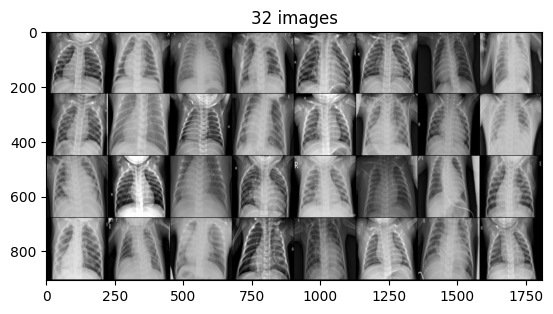

In [113]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataLoader)) # 튜플 (한개의 배치에 들어있는 이미지들, 한개의 배치에 들어있는 정답들)
images_data = torchvision.utils.make_grid(images) # 이미지를 그리드로 만든다

print(labels)
view_img(images_data, '32 images')

# 3. 모델 정의하기/준비하기

## 1) 모델 가져오기

In [136]:
# pretrained 는 deprecated 됨
# pretrained 라는 옵션, 파라미터가 더 이상 사용되지 않는다.
# 이는 곳 없어질수도 있는 위험한 파라미터값이다. > 이후에 이부분이 사라질 가능성 있음!
model = models.efficientnet_b0(pretrained = True)
model

c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\user/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [145]:
from torchvision.models import ResNet34_Weights, EfficientNet_B0_Weights

# y = w1x1 + w2x2 + .... + B
# w1, w2 와 같은 회기계수, 가중치, 파라미터 값을 세부조정할 수 있도록 변경 됨

# pretrained = True 로 설정한 것과 동일하게 작동하는 코드
model = models.efficientnet_b0(weights = EfficientNet_B0_Weights.DEFAULT)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 2) 파인 튜닝하기

### 동결하기

In [146]:
for param in model.parameters():
    param.requires_grad = False

### 분류기 수정하기

In [ ]:
# Renet34
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [150]:
# EfficientNet_B0
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=1000, bias=True)
  )

# 4. 모델 학습하기

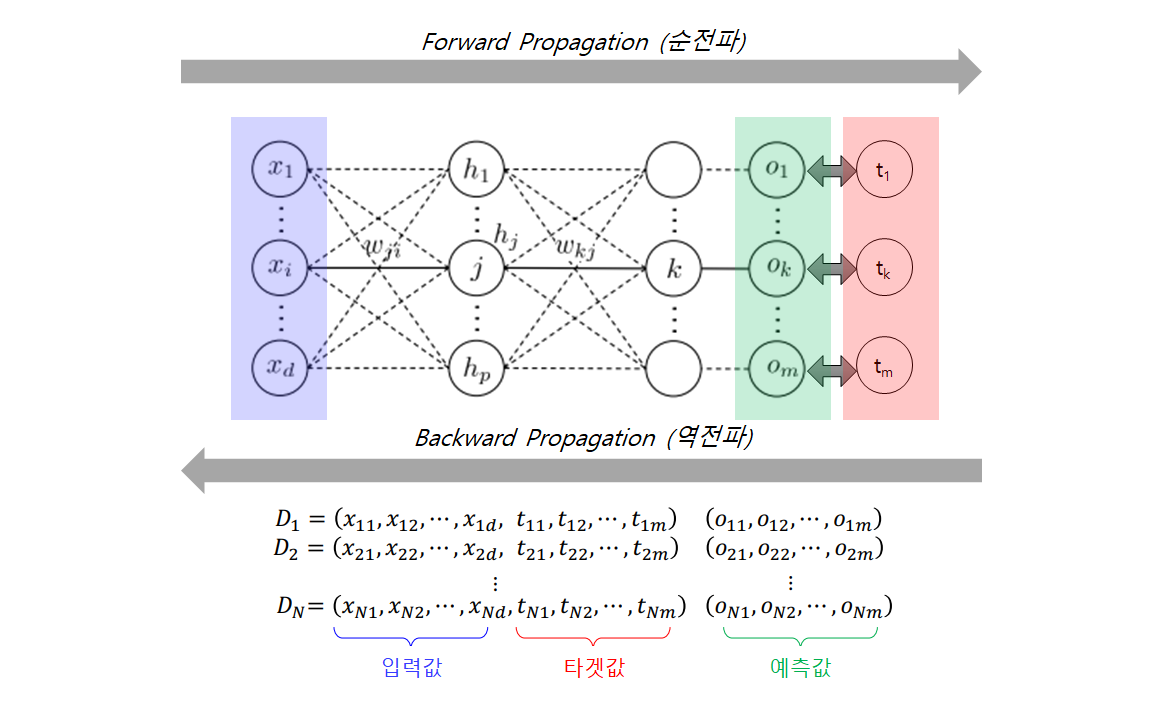

In [159]:
# 모델 학습 큰 흐름
# 1) 순전파
# 2) 손실함수
# 3) 역전파, 파라미터 업데이터

# 모델을 gpu에 넣는다
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optim = Adam(model.parameters(), lr=1e-3) # 최적화 함수 0.001 ~ 0.003
criterion = nn.CrossEntropyLoss()         # 손실함수
epochs = 10

from tensorboardX import SummaryWriter
# 텐서보드 활용하여, 최적화 과정을 시각화 합니다
writer = SummaryWriter()
step = 0

for epoch in range(epochs):
    for images, labels in tqdm.tqdm(train_dataLoader): # (배치사이즈 만큼의 이미지 , 배치사이즈 만큼의 라벨)
        optim.zero_grad() # 📌 최적화 함수를 초기화 해야함 (한 번 학습시 마다)
        
        # 1) 순전파
        preds = model(images.to(device))
        
        # 2) 손실계산
        loss = criterion(preds, labels.to(device))

        # 3) 역전파
        loss.backward()
        optim.step()

        step += 1 # step = step + 1

    print(f"{epoch + 1} loss : {loss}")

100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


1 loss : 0.20466046035289764


100%|██████████| 163/163 [01:15<00:00,  2.17it/s]


2 loss : 0.0666436031460762


100%|██████████| 163/163 [01:16<00:00,  2.12it/s]


3 loss : 0.07352232187986374


100%|██████████| 163/163 [01:25<00:00,  1.91it/s]


4 loss : 0.053665660321712494


100%|██████████| 163/163 [01:30<00:00,  1.81it/s]


5 loss : 0.03032795898616314


100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


6 loss : 0.03763281926512718


100%|██████████| 163/163 [01:29<00:00,  1.81it/s]


7 loss : 0.026093825697898865


100%|██████████| 163/163 [01:27<00:00,  1.87it/s]


8 loss : 0.0329783670604229


100%|██████████| 163/163 [01:23<00:00,  1.96it/s]


9 loss : 0.0313229113817215


100%|██████████| 163/163 [01:26<00:00,  1.88it/s]

10 loss : 0.05095363035798073


💡 가중치 초기화(Weight Initialization)를 해야하는 이유
모델의 층이 깊어질수록,   
활성화 함수 이후 데이터의 분포가 한쪽으로 쏠릴 수 있다.   
이러한 현상은 효율적이고 원활한 모델 학습을 방해한다.

# 5. 모델 저장하기

In [160]:
torch.save(model.state_dict(), 'models/efficientNet_b0_state_20.pth')

In [120]:
torch.save(model, 'models/resnet34_model.pth') # 모델을 통으로 저장

# 6. 모델 평가

In [161]:
load_model = models.resnet34(pretrained=True)
load_model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
load_model.load_state_dict(torch.load('models/resnet34_state.pth', map_location=device))
load_model

c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

f1 스코어로 평가한다

## 테스트하기

In [162]:
from torchmetrics.classification import MulticlassF1Score, BinaryF1Score

# F1 객체 정의 (GPU 쓰면 .to(device))
f1_metric = BinaryF1Score().to(device)

# f1_binary = BinaryF1Score() # 분류할 클래스가 2개이므로 BinaryF1Score 사용
# score = f1_binary(preds, labels)

# 멀티클래스 : 분류할 클래스가 2개 이상일 경우 MulticlassF1Score 사용
# f1_macro = MulticlassF1Score(num_classes=10, average="macro")
# score = f1_macro(preds, target)

model.eval() # 📌 모델을 추론용으로 전환하게 하는 코드

with torch.no_grad(): # 평가 단계이므로 모델이 더이상 학습하지 않도록 막는 코드
    for images, labels in test_dataLoader:

        preds = model(images.to(device)) # [[0일 확률, 1일 확률]]
        
        _, preds = torch.max(preds.data, dim=1) # 0, 1 중 확률이 더 높은 쪽의 인덱스를 반환
        f1_metric.update(preds, labels.to(device))

f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

F1 Score: 0.8775981664657593


## 평가하기

In [158]:
from torchmetrics.classification import MulticlassF1Score, BinaryF1Score

model.eval() # 📌 모델을 추론용으로 전환하게 하는 코드

with torch.no_grad(): # 평가 단계이므로 모델이 더이상 학습하지 않도록 막는 코드
    for images, labels in val_dataLoader: # 테스트와는 평가용 데이터를 사용하는 부분만 다르다

        preds = model(images.to(device))

        _, preds = torch.max(preds.data, dim=1)
        f1_metric.update(preds, labels.to(device))

f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

F1 Score: 0.874316930770874
